# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

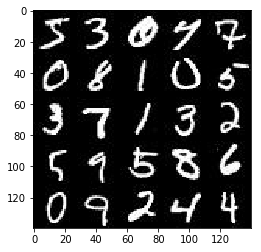

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

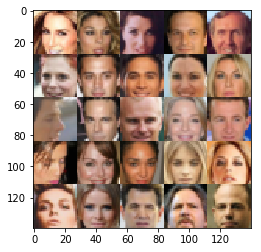

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
    # Input layer is 28x28x3
        alpha = 0.2
        ki_fun = tf.contrib.layers.xavier_initializer()
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=ki_fun)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1,0.8)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=ki_fun)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2,0.8)
        # 7x7x128
        
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=ki_fun)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3,0.8)
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    ki_fun = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1,0.8)
        
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=ki_fun)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2,0.8)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=ki_fun)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3,0.8)
        # 16x16x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same', kernel_initializer=ki_fun)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4,0.8)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=ki_fun)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
#     smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # TODO: Build Model
    
    
    
#     tf.reset_default_graph()
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    saver = tf.train.Saver()
    steps = 0
#     print(len(get_batches(batch_size)))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
#                 if len(batch_images) < batch_size:
#                     steps = 0
#                     continue
                steps += 1
                batch_images = batch_images*2

                
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z,learn_rate:learning_rate})
                
                
                if steps % 20 == 0:
                    train_loss_d = sess.run(d_loss, {input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs), \
                      "Discriminator Loss: {:.4f}...".format(train_loss_d), \
                      "Generator Loss: {:.4f}".format(train_loss_g)) 
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                
                
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.9946... Generator Loss: 2.5436
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 1.6911
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 1.0108
Epoch 1/2... Discriminator Loss: 0.9358... Generator Loss: 1.0193
Epoch 1/2... Discriminator Loss: 2.1079... Generator Loss: 0.3172


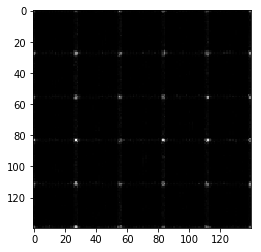

Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.8848
Epoch 1/2... Discriminator Loss: 1.8233... Generator Loss: 0.9318
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.8944
Epoch 1/2... Discriminator Loss: 1.4505... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 1.1867


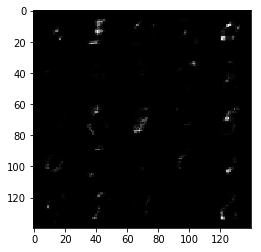

Epoch 1/2... Discriminator Loss: 1.6823... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.5458... Generator Loss: 0.7376
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 1.0066
Epoch 1/2... Discriminator Loss: 1.5299... Generator Loss: 1.0161
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.8390


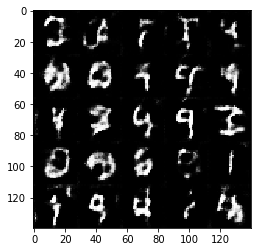

Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 1.0546
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.0447
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.8025


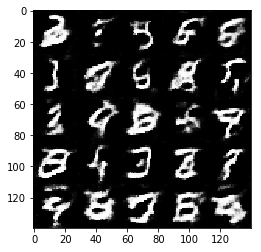

Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 1.0962
Epoch 1/2... Discriminator Loss: 1.0543... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 0.8308


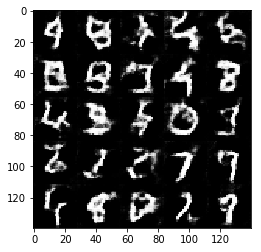

Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 0.9450
Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 0.9638
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 0.8312
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.4959


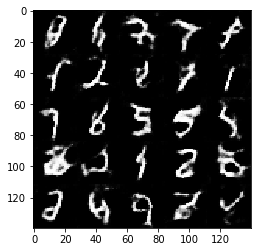

Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 1.0721
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 0.9781
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.8832
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 1.2110


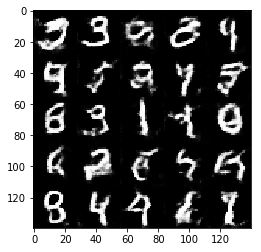

Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.7406
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.5620
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.7280


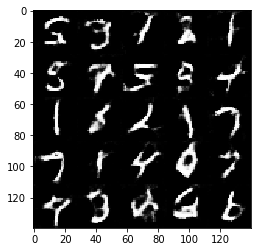

Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 0.8892... Generator Loss: 1.4906
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 1.1163
Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 0.9855
Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 1.1189


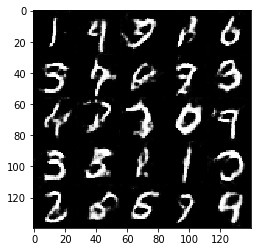

Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 0.9023
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 0.7680
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 0.9475
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 0.8804
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.9959


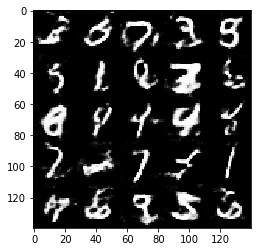

Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 1.2747
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.6099
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.7014


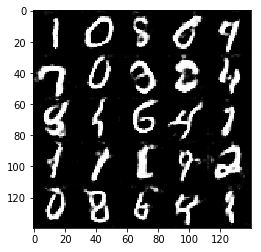

Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 0.9472
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 1.2504
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 1.1559
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.9287


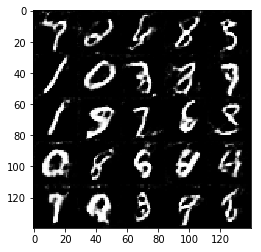

Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 1.1887
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.7683
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 1.9669


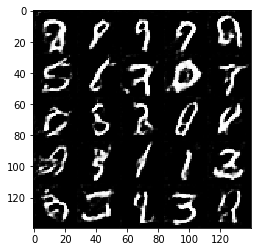

Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.8779
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.9510
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.8109
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.8571


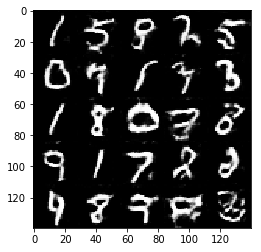

Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 1.2773
Epoch 2/2... Discriminator Loss: 1.0450... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 0.9460
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.7918
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 1.5064


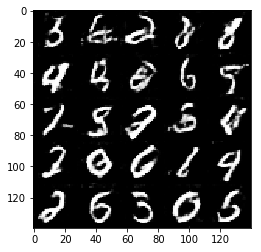

Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 0.9556
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 1.1496
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 1.2380
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 1.0274


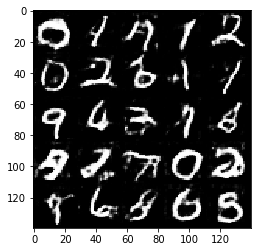

Epoch 2/2... Discriminator Loss: 1.1843... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.6040
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 1.1339
Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 1.5399
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.6736


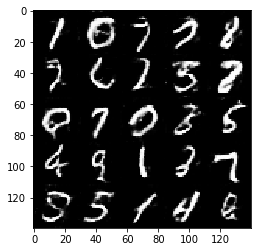

Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 1.1106
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 0.9438
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.7062
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.8312


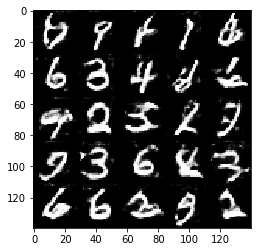

Epoch 2/2... Discriminator Loss: 1.2017... Generator Loss: 0.8214
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 1.2997


In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 2.6575... Generator Loss: 11.4037
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 3.9859
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 1.8591
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 3.8687


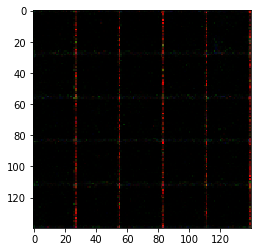

Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 2.5113
Epoch 1/1... Discriminator Loss: 2.6281... Generator Loss: 0.1872
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 2.2976
Epoch 1/1... Discriminator Loss: 2.5952... Generator Loss: 0.1320
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 2.2624


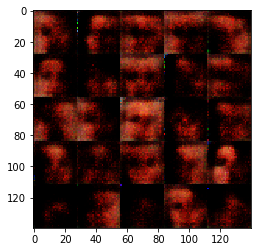

Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.4144
Epoch 1/1... Discriminator Loss: 2.2497... Generator Loss: 0.2376
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 1.7823
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.0320


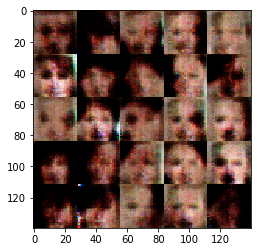

Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.1584
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.9474
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.2232


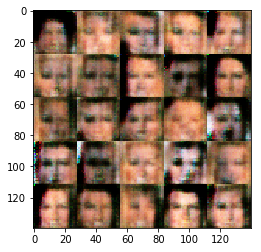

Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.5647
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8131


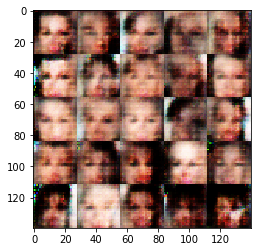

Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.0366


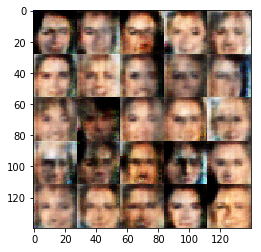

Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.6213... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.5558


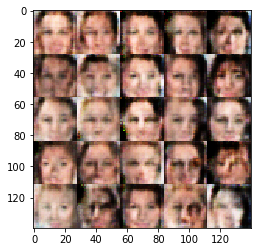

Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.3859
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6981


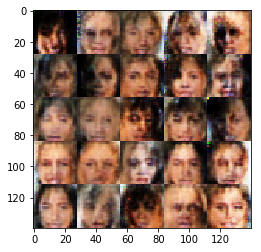

Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6802


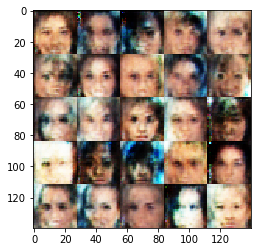

Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.8687


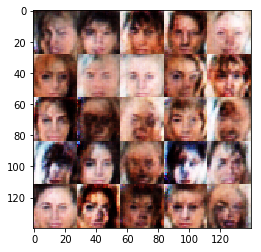

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.6492


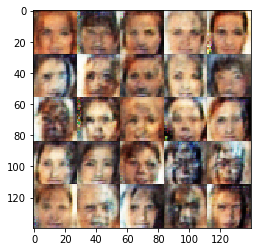

Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.4222
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7709


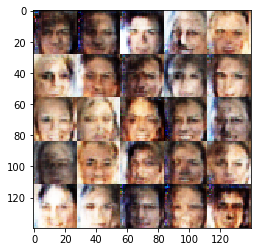

Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6202


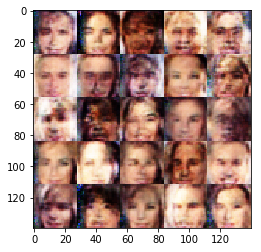

Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.7991


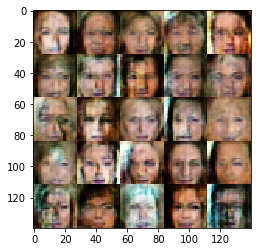

Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8425


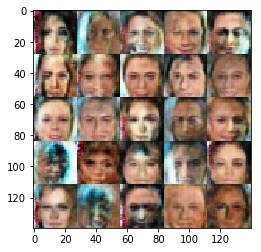

Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7229


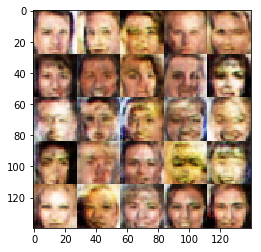

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.6089


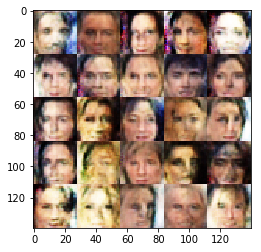

Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7046


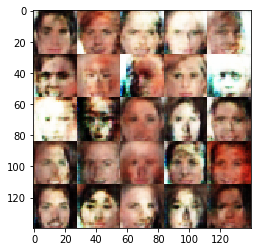

Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.8889


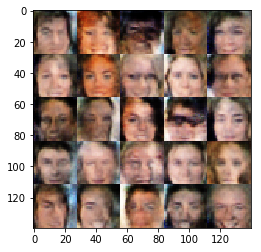

Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.7217


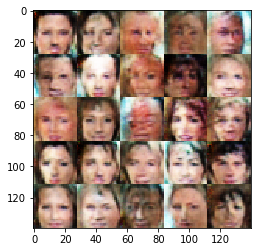

Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6705


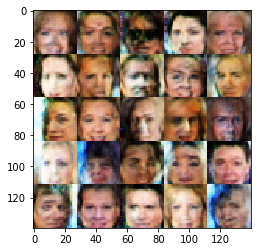

Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6177


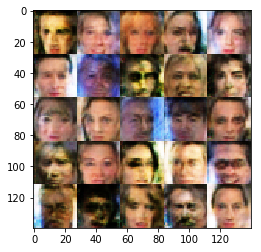

Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.8181


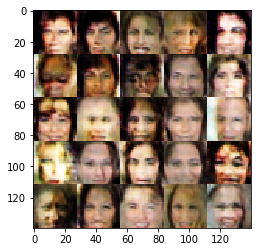

Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.6405


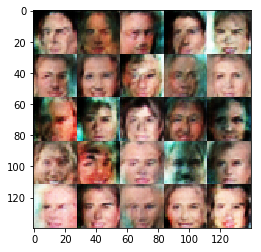

Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7470


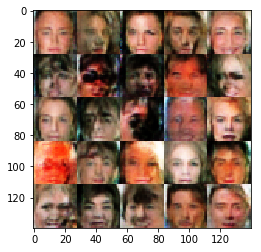

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7363


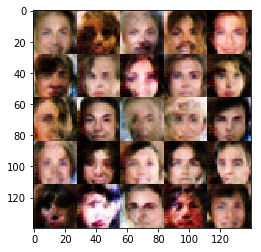

Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7856


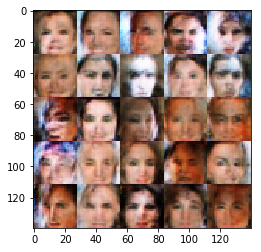

Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.5820


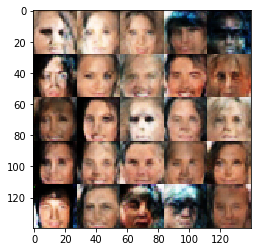

Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6730


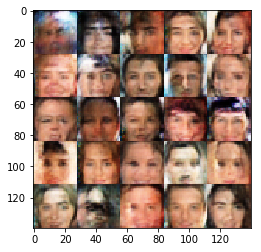

Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6985


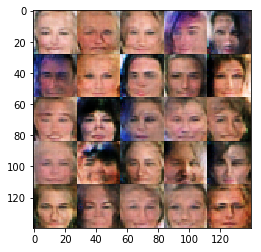

Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6934


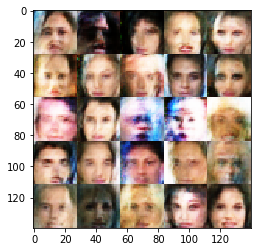

Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6614


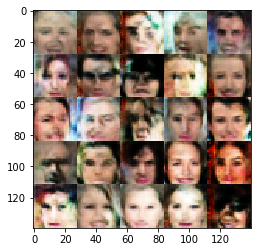

Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.9046


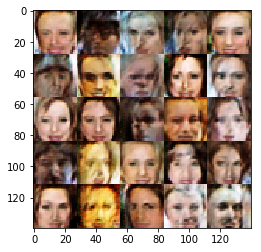

Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7489


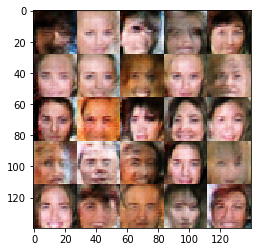

Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7044


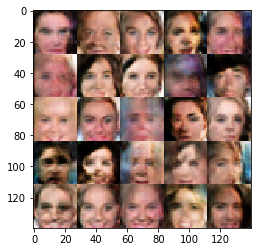

Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7730


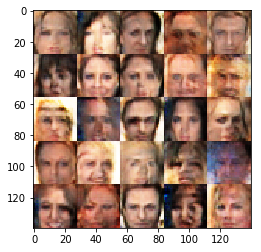

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6715


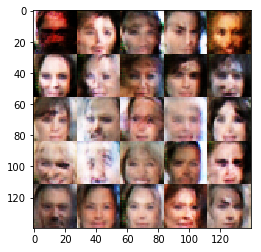

Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.8428


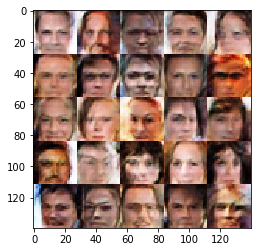

Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7131


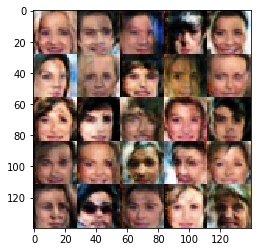

Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7489


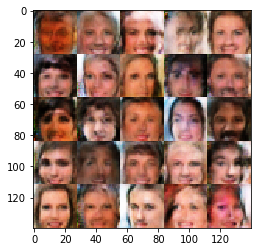

Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6911


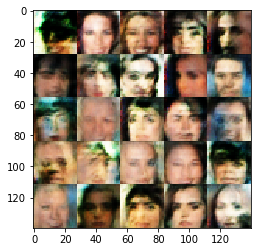

Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6290


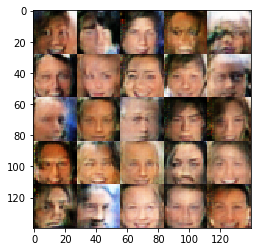

Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.5518


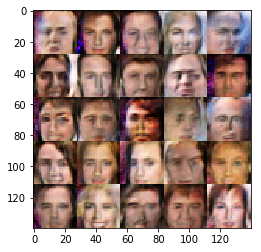

Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6447


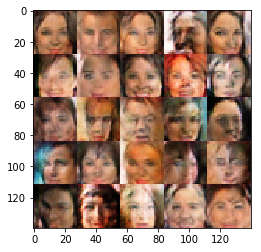

Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7642


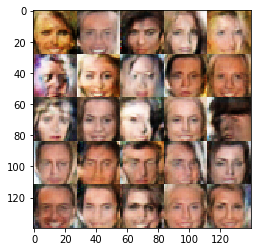

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7645


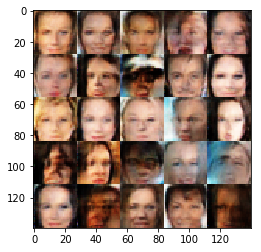

Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6780


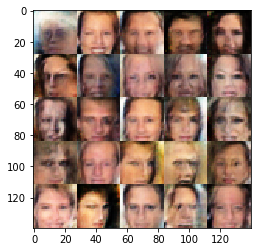

Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7160


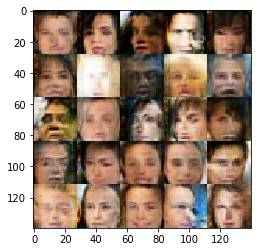

Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6347


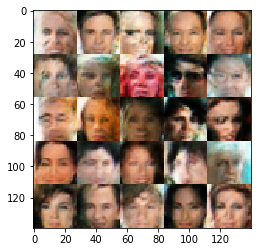

Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7659


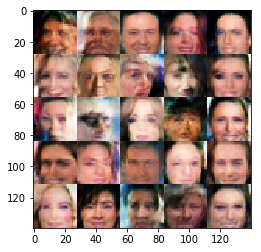

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.7078


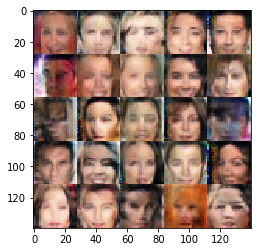

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7153


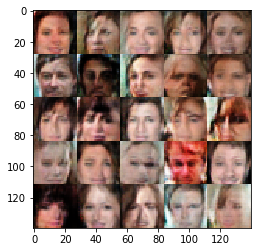

Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.6836


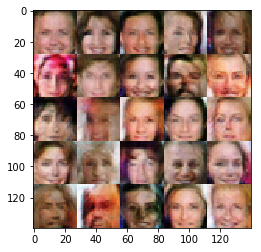

Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7084


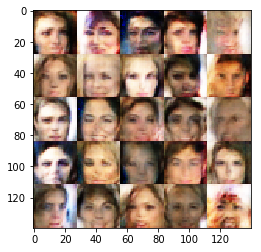

Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6830


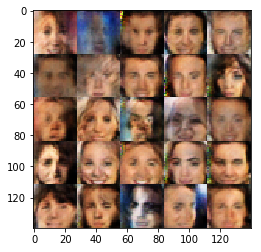

Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.6974


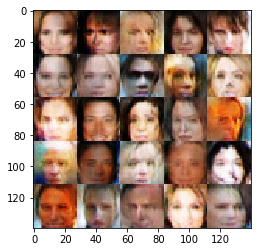

Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7535


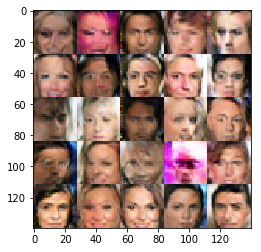

Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6035


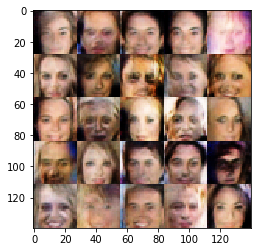

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7015


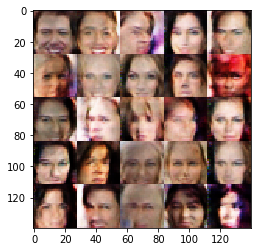

Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6039


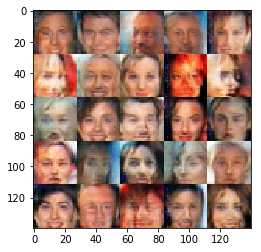

Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7377


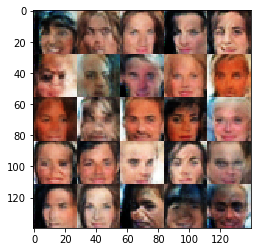

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.6994


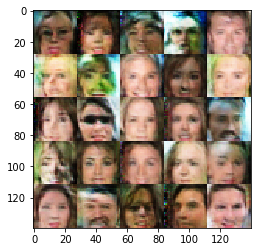

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6776


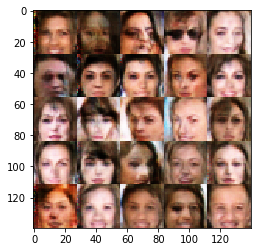

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6817


In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。